# Create HAdamard encoding 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
import scipy.linalg as sl

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS


# For simulation, create a random parent amino acid sequence to create SOLD libraries from

This is an example of a fully in silico path to test and understand the simulator. The functions in the simulator are written such that we can develop models from a given SOLD matrix.
Deep mutational scan at multiple locaitons also conform to the SOLD matrix abstraction 

## Pretend that a set of positions in the protein is mutated--create a sythesis SOLD matrix

In [2]:
length_of_protein = 100
num_mutated = 4
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein, mut_probs = [0.1, 0.1], parent_prob=0.80) #6 postions mutated, pprtein length is 100 
sold_mat_df.head() 
    

Parent protein: WITKMLYCDLHIVQNFNTNCLNGQEINIVVVLPQICMVGKNKDVQETYTFNEECSSDHWLQVSHHMMLDSGAFMWHLLSFRRKHEPKKDAMFVMFKMCTT
Random mutaed positions [16 58 64 73]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

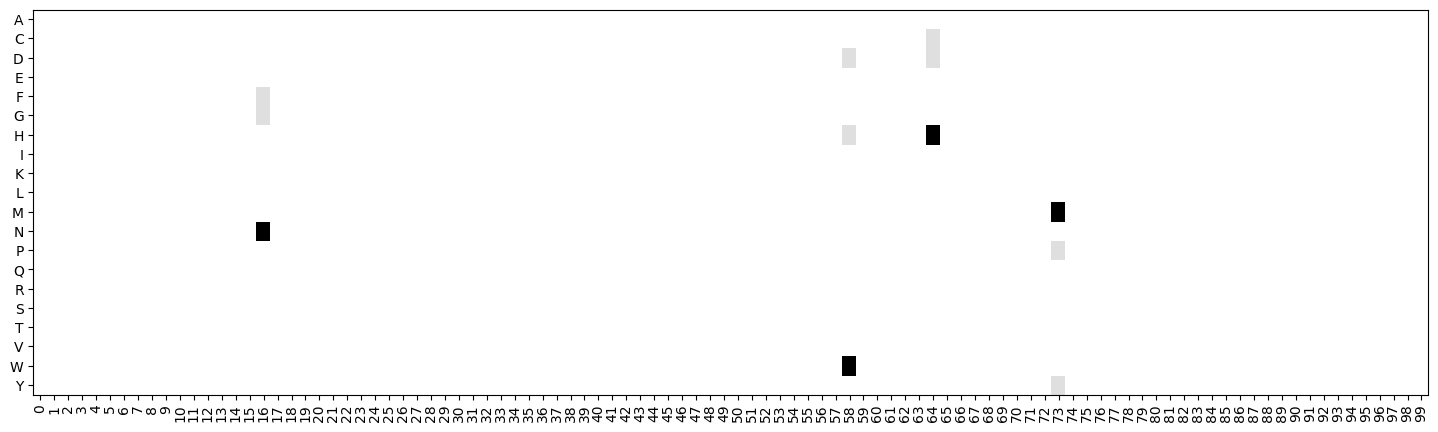

In [3]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


# Now let's try to draw mutated sequences from this matrix 

Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentalist provided SOLD mat

In [4]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)

In [5]:
seqs[0]

'GWHM'

In [6]:
probs = S.compute_prob_n_mutations(num_mutated+1)

Text(0.5, 1.0, 'Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat')

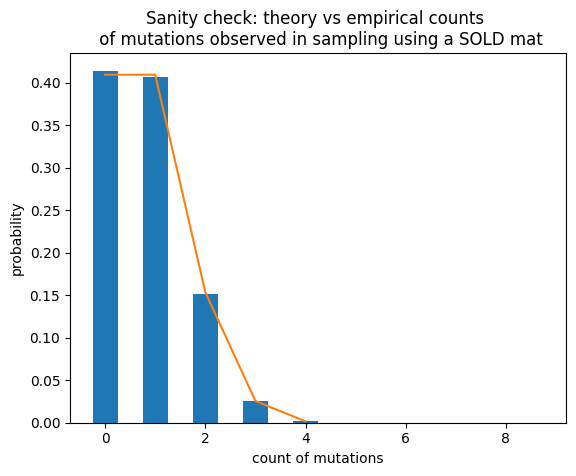

In [7]:
plt.hist(mutations, bins= np.array(range(10)) - 0.25, density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(probs)
plt.title("Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat")

# Now I need to provide weights to the independent and pairwise contributions

I create a mixture of pdfs to draw from, with a zero component (meaning not all independent and pairwise contributions have differential activity compared to parent, some have no effect, and one can control this effect size or model complexity in these simulations) 
Create a mixture of weigthts with random components and some sparse components 

In [8]:
I_params = {'rho':[0.20, 0.20], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 1, 'scale': 0.2}, {'loc': -1, 'scale': 0.2}]} 
P_params = {'rho':[0.20, 0.20], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.01, 'sparse_params': [{'loc': 0.75, 'scale': 0.2}, {'loc': -0.75, 'scale': 0.2}]} 


insilico_model = doe_utils.Create_in_silico_model(S.mutation_probs_variable_region_indexed, independent_params=I_params, pairwise_params=P_params)

In [9]:
#test = doe_utils.Encoding_basics( S.mutation_probs_variable_region_indexed)


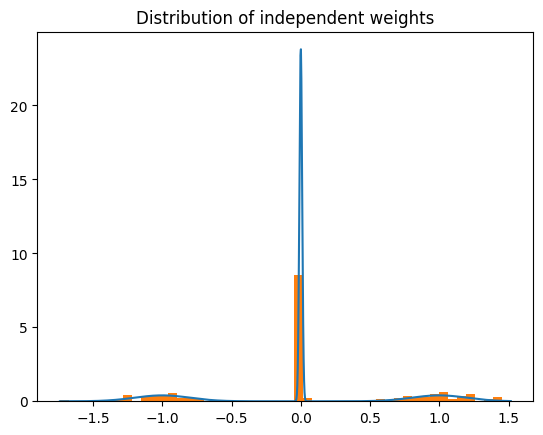

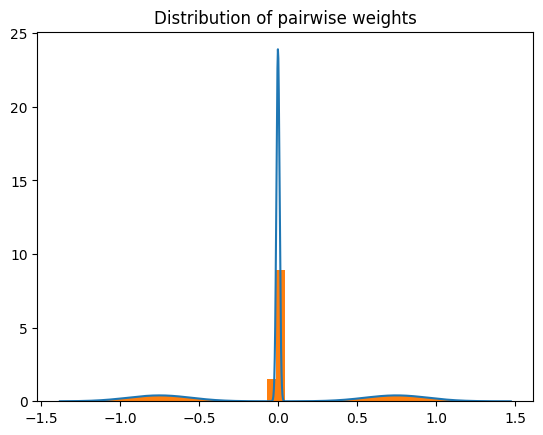

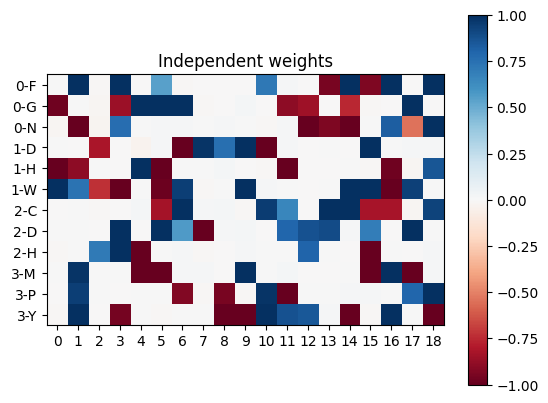

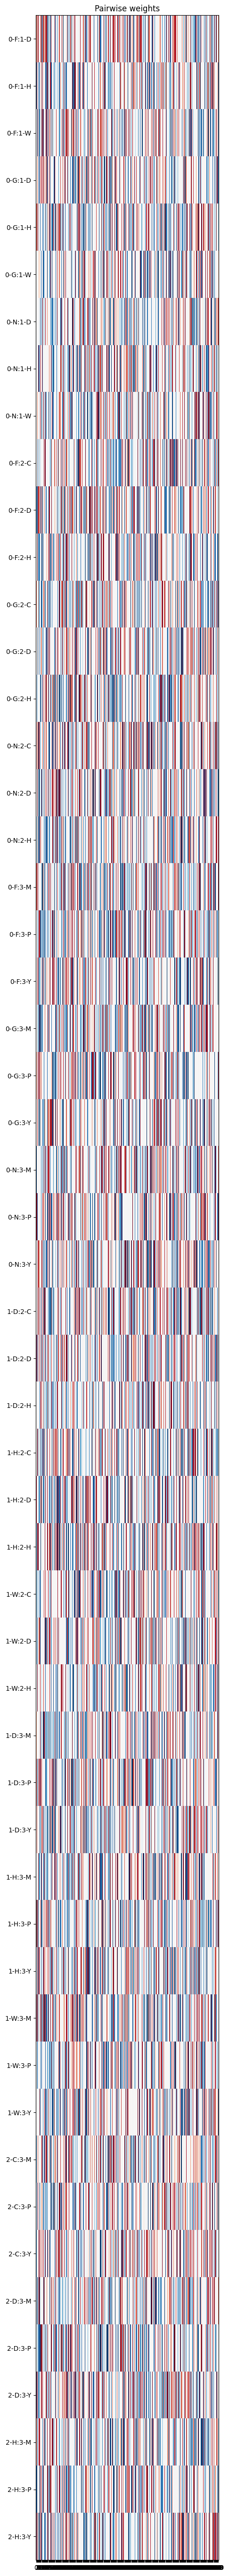

In [10]:
insilico_model.plot_weights()

# ENCODER 

In [11]:
Encoder = doe_utils.Sequence_encoder_simplex( S.mutation_probs_variable_region_indexed)
indp, pair = Encoder.encode_seqs(seqs) 

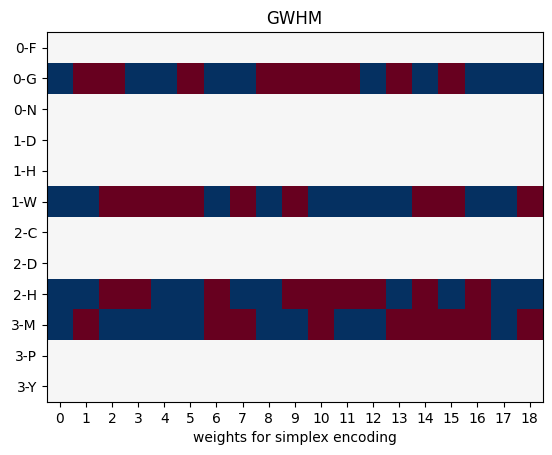

In [12]:
doe_utils.plot_encoding_independent(Encoder, indp[0], seqs[0])

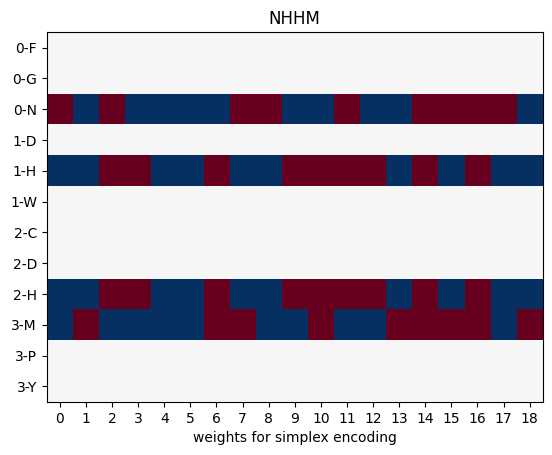

In [13]:
doe_utils.plot_encoding_independent(Encoder, indp[13], seqs[13])

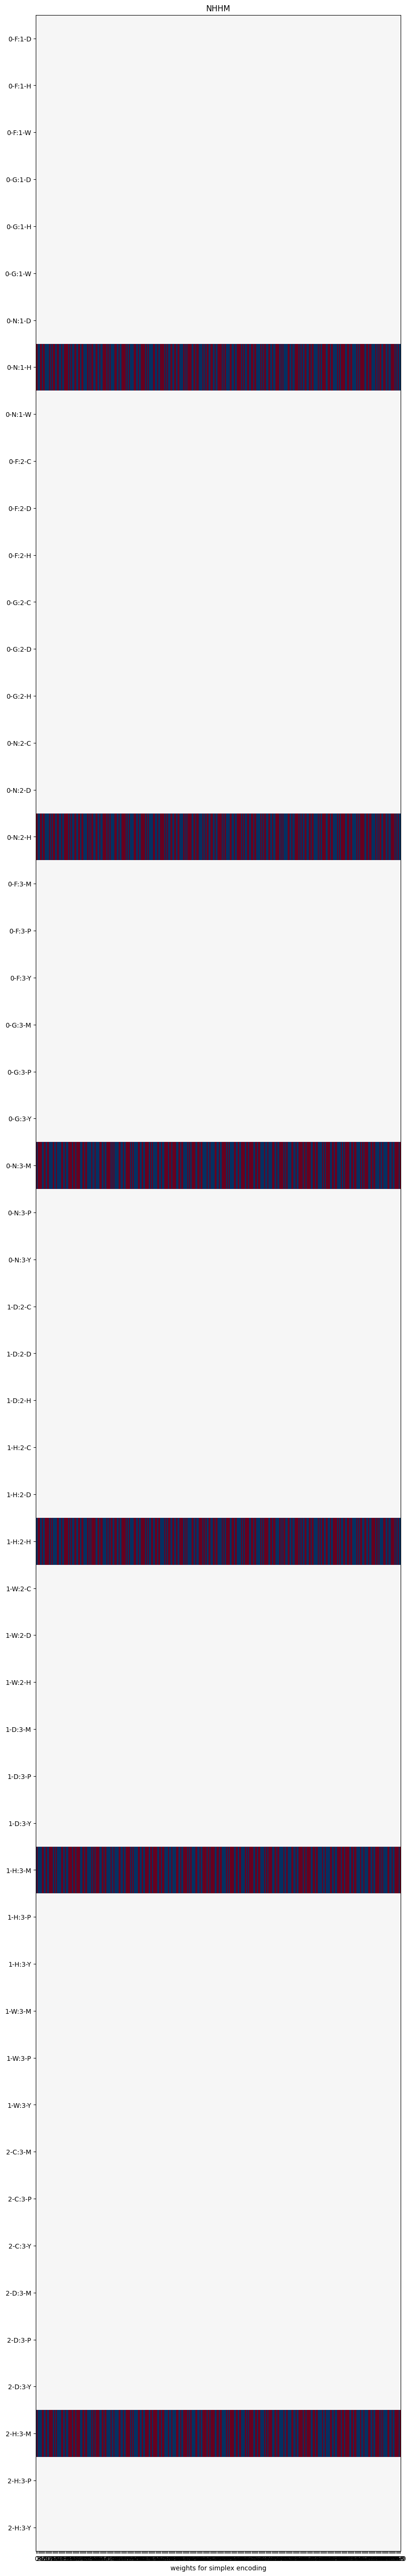

In [14]:
doe_utils.plot_encoding_pairwise(Encoder, pair[13], seqs[13])

# Compute responses 

In [35]:
baseline  = 0 
responses = insilico_model.model(indp, pair, baseline)

Text(0.5, 1.0, 'Distribution of responses')

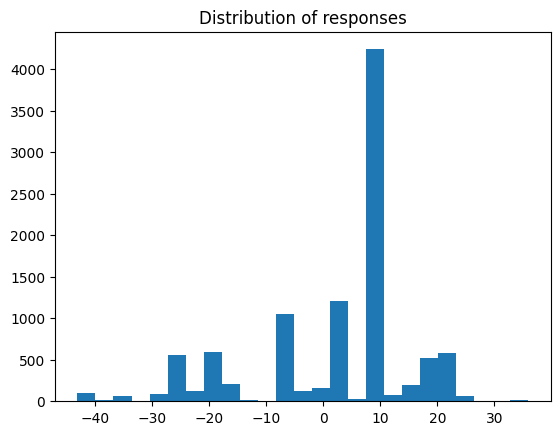

In [36]:
_ = plt.hist(responses, bins = 25)
plt.title('Distribution of responses') 

# Now do sparse (elastic net) linear regression to learn back the weights 

In [37]:
from doe_utils import Encoding_basics, Sequence_encoder_simplex
from sklearn.linear_model import Lasso

class Fitting_model(Encoding_basics): 
    """
    l1 norm fitting model of data, with different penalty for indepednent and pairwise parameters 
    """
    def __init__(self, mutation_probs_variable_region_dict): 
        """
        I need to SOLD matrix dict to get to the right parameters to fit 
        
        Args: 
            pass the dict of mutation probs (this is generated by SOLD matrix class, attribute of dict is called mutation_probs_variable_region_indexed) 
            MUST BE INDEXED BY THE POSITION OF THE MUTATED REGION, not the portein position... thsi is to make sure we can deal with different length proteins 

            example:
            {0: {'D': 0.05, 'K': 0.85, 'M': 0.05, 'Y': 0.05},
             1: {'C': 0.05, 'G': 0.05, 'I': 0.05, 'P': 0.85},
             2: {'F': 0.05, 'N': 0.05, 'R': 0.85, 'Y': 0.05},
             3: {'G': 0.05, 'I': 0.05, 'L': 0.85, 'Q': 0.05},
             4: {'A': 0.05, 'E': 0.05, 'R': 0.05, 'W': 0.85},
             5: {'A': 0.05, 'D': 0.05, 'I': 0.85, 'K': 0.05}}
            where the keys are the index of the mutated regions and the values are dicts of probs of each amino acid
        
        """
        super().__init__(mutation_probs_variable_region_dict) 


    def fit(self, seqs, activities, lambda_I = 0.0001, lambda_P = 0.1): 
        """
        Fit seqs to their activities 
        The seqs are ONLY variable regions seqs concatenated! No point trying to fit regions that don't vary in the SOLD experiment! 
        Args: 
            seqs
            activities: vector of real values 
        """
        assert len(seqs) == len(activities), "Seqs (X) and activities (y) should be same length vectors"
        self.encoder = Sequence_encoder_simplex(self.mutation_probs_variable_region_dict) 
        I_encodings, P_encodings = self.encoder.encode_seqs(seqs)
        self.features = np.asarray([np.concatenate((np.ravel(indt), np.ravel(pair))) for indt, pair in zip(I_encodings, P_encodings)])  
        self.number_of_features = np.prod(self.shape_independent_weights) + np.prod(self.shape_pairwise_weights) 
        self.independent_indices = np.arange(np.prod(self.shape_independent_weights)) # first few are independent features 
        self.pairwise_indices = np.arange(np.prod(self.shape_independent_weights), self.number_of_features)  # these a are the pariwise features 
        # beta = cp.Variable(self.number_of_features)
        # loss = cp.sum_squares(activities - self.features @ beta)    
        # penalty = (lambda_I * cp.norm1(beta[self.independent_indices]) +
        #            lambda_P * cp.norm1(beta[self.pairwise_indices]))
        # objective = cp.Minimize(loss + penalty)
        # # Define the problem and solve
        # problem = cp.Problem(objective)
        # problem.solve()     

        lasso_model = Lasso(alpha=lambda_I, random_state=42)
        lasso_model.fit(self.features, activities)
        #predicted_activities = np.dot(self.features, beta.value) 
        predicted_activities = np.dot(self.features, lasso_model.coef_)
        #return beta.value, predicted_activities  
        return lasso_model.coef_, predicted_activities

    

In [38]:
F = Fitting_model(S.mutation_probs_variable_region_indexed)

In [39]:
fitted_params, predicted_actvities = F.fit(seqs, responses) 

/Users/swagatammukhopadhyay/anaconda3/envs/pytorch_env/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e+02, tolerance: 1.918e+02
  model = cd_fast.enet_coordinate_descent(


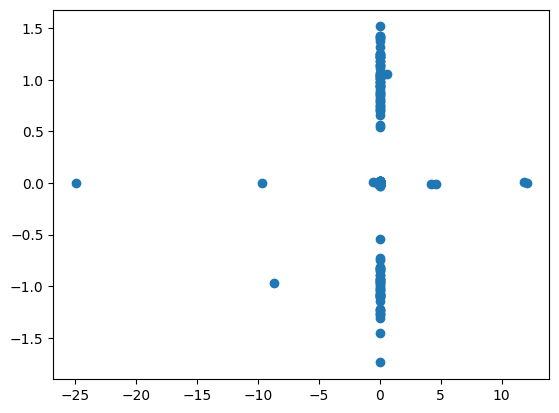

In [40]:
plt.scatter(fitted_params[F.independent_indices], np.ravel(insilico_model.independent_weights))

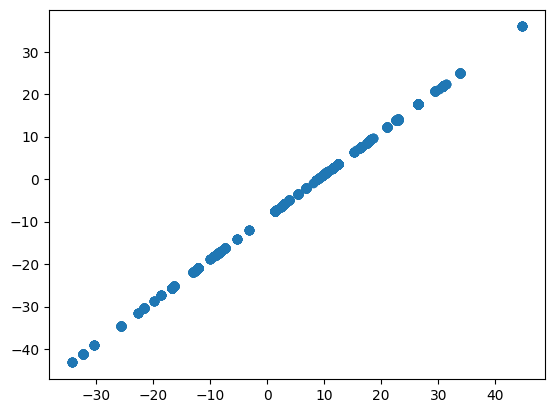

In [41]:
plt.scatter(predicted_actvities, responses)

In [ ]:
plt.scatter(fitted_params[fit_model.independent_indices], Model_in_silico.independent_weights[Model_in_silico.independent_mask])
plt.title('independent params')

In [43]:
np.sum(Encoder.pairwise_base_codes, axis = 0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [44]:
Encoder.pairwise_base_codes.dot(Encoder.pairwise_base_codes.T)

array([[361, -19, -19, ...,   1,   1,   1],
       [-19, 361, -19, ...,   1,   1,   1],
       [-19, -19, 361, ...,   1,   1,   1],
       ...,
       [  1,   1,   1, ..., 361, -19, -19],
       [  1,   1,   1, ..., -19, 361, -19],
       [  1,   1,   1, ..., -19, -19, 361]], shape=(400, 400))

In [46]:
Encoder.independent_codes.dot(Encoder.independent_codes.T)

array([[19, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, 19, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, 19, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, 19, -1, -1, -1, 19, -1, -1, -1, -1],
       [-1, -1, -1, -1, 19, -1, -1, -1, 19, -1, -1, -1],
       [-1, -1, -1, -1, -1, 19, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, 19, -1, -1, -1, -1, -1],
       [-1, -1, -1, 19, -1, -1, -1, 19, -1, -1, -1, -1],
       [-1, -1, -1, -1, 19, -1, -1, -1, 19, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, 19, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 19, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 19]])

In [ ]:
np.sum(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)) < 0.0001)

In [ ]:
print("Cant account for ... ") 

np.sum(scipy.linalg.svdvals(fit_model.features.T.dot(fit_model.features)) < 0.0001) -np.shape(fit_model.constraints)[0]

In [ ]:
np.shape(Model_in_silico.pairwise_weights)

In [ ]:
np.shape(fit_model.constraints)

In [ ]:
np.shape(fit_model.independent_indices)

In [ ]:
np.shape(fit_model.pairwise_indices)

In [ ]:
import re

A = np.asarray([re.split(':' + "|" + '-', a) for a in Model_in_silico.feature_names_pairwise]) 

collector = [] 
for a in A: 
    if a[1] != a[3]:
        collector.append(a)
    

In [ ]:
np.shape(fit_model.independent_indices)

In [ ]:
ij = [a+b for a,b in zip(A[:,1],A[:,3])]
len(np.unique(ij))

In [ ]:
np.unique([[a,b] for a,b in zip(A[:,0], A[:,2])], axis = 0)

In [ ]:
A[:, [0, 2]]

In [ ]:
inds = np.all(A[:, [0,2]] == ['0', '1'], axis = 1)
inds

In [ ]:
A[inds]

In [ ]:

plt.figure(figsize = (5, 70))
plt.imshow(encodings[1][0], aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 1, cmap = 'Greys')
_  = plt.xticks(range(len(Encoder.pos_product)), Encoder.pos_product, rotation = 90)
_  = plt.yticks(range(len(Encoder.amino_product)), Encoder.amino_product)
plt.title(seqs[0]) 

In [ ]:
plt.imshow(encodings[0][0])

In [ ]:
np.max([1,2,3])